This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

### Processing words as a sequence: The sequence model approach

#### A first practical example

**Downloading the data**

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  14.5M      0  0:00:05  0:00:05 --:--:-- 18.1M


**Preparing the data**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [3]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [4]:
!pip install tensorflow==2.12



INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 10.1 MB/s eta 0:00:00
  At

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM, Dropout
from keras.models import load_model
from keras.optimizers import RMSprop
from google.colab import files
import re, os

Consider the IMDB example from Chapter 11 (Section 11.3, chapter11_part02_sequence-
models.ipynb). Re-run the example modifying the following:
1) Cutoff reviews after 150 words
2) Restrict training samples to 100
3) Validate on 10,000 samples
4) Consider only the top 10,000 words

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters
VOCAB_SIZE = 10000  # Top 10,000 words
MAX_REVIEW_LENGTH = 150  # Cutoff reviews after 150 words
TRAIN_SAMPLES = 100  # Restrict training samples to 100
VAL_SAMPLES = 10000  # Validate on 10,000 samples

# Load and prepare the data
(x_train_original, y_train_original), (x_test_original, y_test_original) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to MAX_REVIEW_LENGTH
x_train_padded = pad_sequences(x_train_original, maxlen=MAX_REVIEW_LENGTH)
x_test_padded = pad_sequences(x_test_original, maxlen=MAX_REVIEW_LENGTH)

# Combine all data for stratified splitting
x_all = np.concatenate((x_train_padded, x_test_padded), axis=0)
y_all = np.concatenate((y_train_original, y_test_original), axis=0)

# Create small training set and validation set
x_small_train, x_val, y_small_train, y_val = train_test_split(
    x_all, y_all,
    train_size=TRAIN_SAMPLES,
    test_size=VAL_SAMPLES,
    random_state=42,
    stratify=y_all
)

# Create final test set (5000 samples)
_, x_final_test, _, y_final_test = train_test_split(
    x_test_padded, y_test_original,
    test_size=5000,
    random_state=42,
    stratify=y_test_original
)

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
x_small_train.shape

(100, 150)

In [4]:
x_val.shape

(10000, 150)

In [5]:
x_final_test.shape


(5000, 150)

Building the model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Define the sentiment analysis model
sentiment_classifier = Sequential()

# Add embedding layer with 10,000 word vocabulary, 8-dimensional embeddings
sentiment_classifier.add(Embedding(
    input_dim=VOCAB_SIZE,         # Top 10,000 words
    output_dim=8,                  # 8-dimensional embedding vectors
    input_length=MAX_REVIEW_LENGTH # Input sequence length of 150 words
))

# Flatten the 3D tensor of embeddings into 2D
sentiment_classifier.add(Flatten())

# Final classification layer with sigmoid activation
sentiment_classifier.add(Dense(
    units=1,                      # Single output unit (positive/negative)
    activation='sigmoid'          # Sigmoid for binary classification
))

# Compile the model with RMSprop optimizer
sentiment_classifier.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',   # Binary crossentropy for binary classification
    metrics=['accuracy']          # Track accuracy during training
)

# Display model architecture
sentiment_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


Executing the model

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath="sentiment_classifier.h5",
    save_best_only=True,
    monitor="val_loss"
)

train_history = sentiment_classifier.fit(
    x_small_train, y_small_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback]
)


Epoch 1/30
4/4 [==============================] - 1s 159ms/step - loss: 0.6941 - accuracy: 0.4800 - val_loss: 0.6930 - val_accuracy: 0.5098
Epoch 2/30
4/4 [==============================] - 0s 113ms/step - loss: 0.6724 - accuracy: 0.8400 - val_loss: 0.6930 - val_accuracy: 0.5101
Epoch 3/30
4/4 [==============================] - 0s 110ms/step - loss: 0.6568 - accuracy: 0.9600 - val_loss: 0.6930 - val_accuracy: 0.5118
Epoch 4/30
4/4 [==============================] - 0s 97ms/step - loss: 0.6436 - accuracy: 0.9800 - val_loss: 0.6930 - val_accuracy: 0.5083
Epoch 5/30
4/4 [==============================] - 0s 95ms/step - loss: 0.6304 - accuracy: 0.9900 - val_loss: 0.6930 - val_accuracy: 0.5048
Epoch 6/30
4/4 [==============================] - 0s 109ms/step - loss: 0.6176 - accuracy: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 7/30
4/4 [==============================] - 0s 109ms/step - loss: 0.6047 - accuracy: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 8/30
4/4 [======

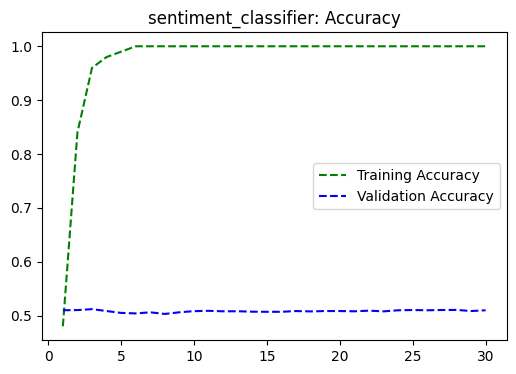

<Figure size 640x480 with 0 Axes>

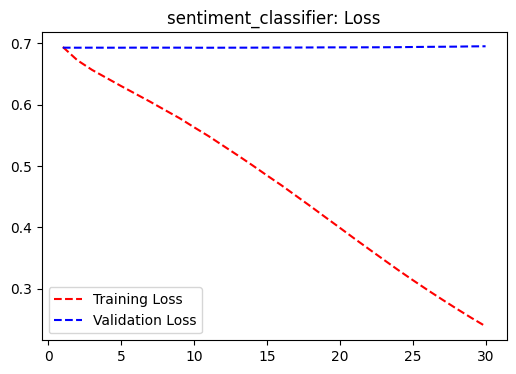

In [8]:
import matplotlib.pyplot as plt

train_accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy']

train_loss = train_history.history["loss"]
val_loss = train_history.history["val_loss"]

epoch_range = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epoch_range, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("sentiment_classifier: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epoch_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("sentiment_classifier: Loss")
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.models import load_model

# Loading the saved model
loaded_model = load_model('sentiment_classifier.h5')

# Evaluating the model on the test data
evaluation_results = loaded_model.evaluate(x_final_test, y_final_test)

# Printing the results (Loss and Accuracy)
print(f'Loss: {evaluation_results[0]:.3f}')
print(f'Accuracy: {evaluation_results[1]:.3f}')

157/157 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.5078
Loss: 0.693
Accuracy: 0.508


**Model 2: Baseline Model with Embedded Layer (Training Sample Size: 10,000)**

In [10]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Constants for data configuration
MAX_VOCAB_SIZE = 10000          # Consider only top 10,000 words
MAX_SEQUENCE_LENGTH = 150       # Truncate/pad reviews to 150 words

# Load and preprocess the IMDB dataset
(train_reviews, train_sentiments), (test_reviews, test_sentiments) = imdb.load_data(
    num_words=MAX_VOCAB_SIZE
)

# Pad sequences to uniform length
padded_train_reviews = pad_sequences(train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for stratified splitting
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((train_sentiments, test_sentiments), axis=0)

# Create training (10,000 samples) and validation (10,000 samples) sets
train_reviews_final, val_reviews, train_sentiments_final, val_sentiments = train_test_split(
    all_reviews,
    all_sentiments,
    train_size=10000,
    test_size=10000,
    random_state=42,
    stratify=all_sentiments
)


_, test_reviews_final, _, test_sentiments_final = train_test_split(
    padded_test_reviews,
    test_sentiments,
    test_size=5000,
    random_state=42,
    stratify=test_sentiments
)

In [11]:
train_reviews_final.shape

(10000, 150)

In [12]:
val_reviews.shape

(10000, 150)

In [13]:
test_reviews_final.shape

(5000, 150)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Initialize a sequential model for sentiment analysis
sentiment_analysis_model = Sequential()

# Add an embedding layer that converts word indices to dense vectors
sentiment_analysis_model.add(Embedding(
    input_dim=MAX_VOCAB_SIZE,      # Size of vocabulary (10,000 words)
    output_dim=8,                  # Dimension of word embeddings
    input_length=MAX_SEQUENCE_LENGTH  # Length of input sequences (150 words)
))

# Flatten the 3D embedding output to 2D for the dense layer
sentiment_analysis_model.add(Flatten())

# Add final classification layer with sigmoid activation
sentiment_analysis_model.add(Dense(
    units=1,                      # Single output unit for binary classification
    activation='sigmoid'          # Sigmoid activation for probability output
))

# Compile the model with appropriate settings for binary classification
sentiment_analysis_model.compile(
    optimizer='rmsprop',          # RMSprop optimizer
    loss='binary_crossentropy',   # Binary cross-entropy loss function
    metrics=['accuracy']          # Track accuracy during training
)

# Display the model architecture summary
sentiment_analysis_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Setup model checkpoint to save the best version during training
model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_model.h5",  # More descriptive filename
    save_best_only=True,                # Only keep the best model
    monitor="val_loss",                 # Monitor validation loss

)

# Train the sentiment analysis model
train_history1 = sentiment_analysis_model.fit(
    x_small_train, y_small_train,
    epochs=30,                         # Number of training epochs
    batch_size=32,                     # Batch size
    validation_data=(x_val, y_val),  # Validation data
    callbacks=[model_checkpoint],      # Include our checkpoint callback

)

Epoch 1/30
4/4 [==============================] - 1s 184ms/step - loss: 0.6959 - accuracy: 0.4700 - val_loss: 0.6928 - val_accuracy: 0.5085
Epoch 2/30
4/4 [==============================] - 1s 222ms/step - loss: 0.6734 - accuracy: 0.8100 - val_loss: 0.6927 - val_accuracy: 0.5090
Epoch 3/30
4/4 [==============================] - 0s 104ms/step - loss: 0.6581 - accuracy: 0.9100 - val_loss: 0.6925 - val_accuracy: 0.5093
Epoch 4/30
4/4 [==============================] - 0s 114ms/step - loss: 0.6447 - accuracy: 0.9500 - val_loss: 0.6925 - val_accuracy: 0.5081
Epoch 5/30
4/4 [==============================] - 0s 112ms/step - loss: 0.6317 - accuracy: 0.9600 - val_loss: 0.6924 - val_accuracy: 0.5079
Epoch 6/30
4/4 [==============================] - 0s 115ms/step - loss: 0.6188 - accuracy: 0.9600 - val_loss: 0.6923 - val_accuracy: 0.5117
Epoch 7/30
4/4 [==============================] - 0s 113ms/step - loss: 0.6058 - accuracy: 0.9600 - val_loss: 0.6923 - val_accuracy: 0.5109
Epoch 8/30
4/4 [====

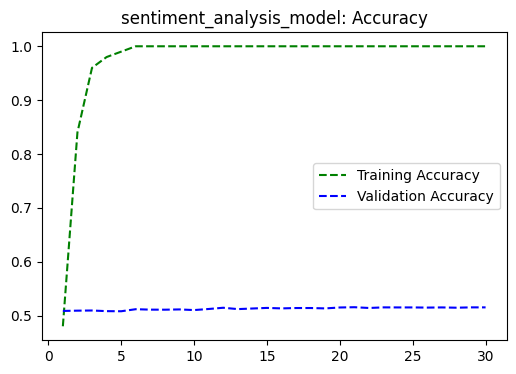

<Figure size 640x480 with 0 Axes>

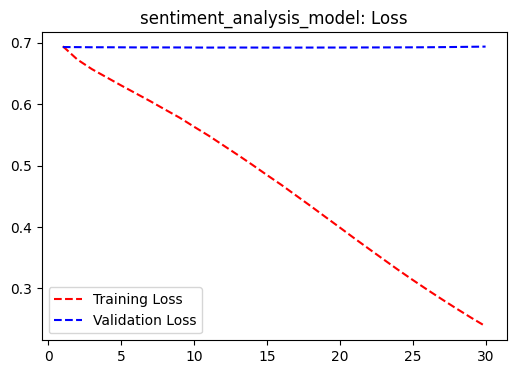

In [16]:
import matplotlib.pyplot as plt

val_accuracy = train_history1.history['val_accuracy']

training_loss = train_history1.history['loss']
val_loss = train_history1.history['val_loss']

epochs_range = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("sentiment_analysis_model: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("sentiment_analysis_model: Loss")
plt.legend()
plt.show()

In [17]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_sentiment_model.h5')

evaluation_results = loaded_model.evaluate(test_reviews_final, test_sentiments_final)
print(f'Loss: {evaluation_results[0]:.3f}')
print(f'Accuracy: {evaluation_results[1]:.3f}')

157/157 [==============================] - 0s 919us/step - loss: 0.6927 - accuracy: 0.5160
Loss: 0.693
Accuracy: 0.516


**Model 3: Baseline Model with Embedded Layer (Training Sample Size: 15,000)**



In [18]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
VOCABULARY_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load and preprocess IMDB dataset
((raw_train_reviews, raw_train_labels), (raw_test_reviews, raw_test_labels)) = imdb.load_data(num_words=VOCABULARY_SIZE)
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for stratified splitting
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_labels = np.concatenate((raw_train_labels, raw_test_labels), axis=0)

# Create training and validation sets
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    all_reviews, all_labels,
    train_size=15000,
    test_size=10000,
    random_state=42,
    stratify=all_labels
)

# Create final test set
_, final_test_reviews, _, final_test_labels = train_test_split(
    padded_test_reviews,
    raw_test_labels,
    test_size=5000,
    random_state=42,
    stratify=raw_test_labels
)

In [19]:
train_reviews.shape

(15000, 150)

In [20]:
val_reviews.shape

(10000, 150)

In [21]:
final_test_reviews.shape

(5000, 150)

Building model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Define the model architecture
sentiment_analysis_model = Sequential()
sentiment_analysis_model.add(Embedding(
    input_dim=VOCABULARY_SIZE,
    output_dim=8,
    input_length=MAX_SEQUENCE_LENGTH,
    name='word_embedding_layer'
))
sentiment_analysis_model.add(Flatten(name='flatten_layer'))
sentiment_analysis_model.add(Dense(
    units=1,
    activation='sigmoid',
    name='output_layer'
))

# Compile the model
sentiment_analysis_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
sentiment_analysis_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_embedding_layer (Embed  (None, 150, 8)           80000     
 ding)                                                           
                                                                 
 flatten_layer (Flatten)     (None, 1200)              0         
                                                                 
 output_layer (Dense)        (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define model checkpoint callback to save the best model
best_model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"   # Explicitly set to minimize validation loss
)

# Train the model with checkpointing
model_training_history = sentiment_analysis_model.fit(
    x=train_reviews,  # Using our renamed variables from earlier
    y=train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_reviews, val_labels),  # Using our renamed validation set
    callbacks=[best_model_checkpoint],

)

Epoch 1/30
469/469 [==============================] - 2s 3ms/step - loss: 0.6436 - accuracy: 0.6587 - val_loss: 0.5210 - val_accuracy: 0.7852
Epoch 2/30
469/469 [==============================] - 1s 2ms/step - loss: 0.3976 - accuracy: 0.8475 - val_loss: 0.3561 - val_accuracy: 0.8487
Epoch 3/30
469/469 [==============================] - 1s 2ms/step - loss: 0.2890 - accuracy: 0.8863 - val_loss: 0.3095 - val_accuracy: 0.8657
Epoch 4/30
469/469 [==============================] - 1s 2ms/step - loss: 0.2407 - accuracy: 0.9065 - val_loss: 0.2987 - val_accuracy: 0.8705
Epoch 5/30
469/469 [==============================] - 1s 2ms/step - loss: 0.2077 - accuracy: 0.9210 - val_loss: 0.2918 - val_accuracy: 0.8746
Epoch 6/30
469/469 [==============================] - 1s 2ms/step - loss: 0.1811 - accuracy: 0.9349 - val_loss: 0.2931 - val_accuracy: 0.8739
Epoch 7/30
469/469 [==============================] - 1s 2ms/step - loss: 0.1590 - accuracy: 0.9454 - val_loss: 0.2976 - val_accuracy: 0.8736
Epoch 

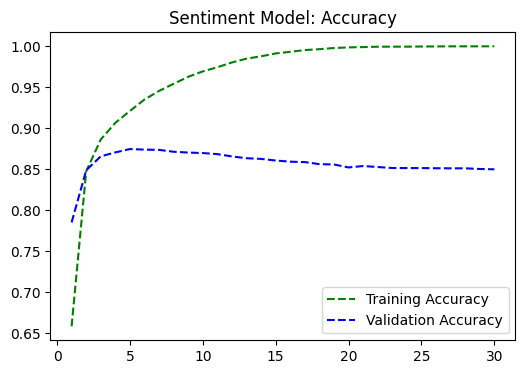

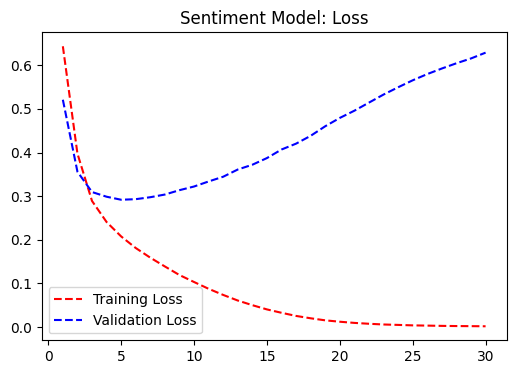

In [24]:
import matplotlib.pyplot as plt

# Extract metrics using the renamed history variable
training_accuracy = model_training_history.history['accuracy']
validation_accuracy = model_training_history.history['val_accuracy']
training_loss = model_training_history.history['loss']
validation_loss = model_training_history.history['val_loss']

# Create epoch range (unchanged)
epochs_range = range(1, len(training_accuracy) + 1)

# Accuracy plot (identical style, just variable names changed)
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, training_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Model: Accuracy")
plt.legend()

# Loss plot (identical style, just variable names changed)
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, training_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, validation_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Model: Loss")
plt.legend()

plt.show()

In [25]:
from tensorflow.keras.models import load_model

# Load the saved model
trained_sentiment_model = load_model('best_sentiment_model.h5')

# Evaluate model performance
model_evaluation_metrics = trained_sentiment_model.evaluate(final_test_reviews, final_test_labels)
print(f'Test Loss: {model_evaluation_metrics[0]:.3f}')
print(f'Test Accuracy: {model_evaluation_metrics[1]:.3f}')

157/157 [==============================] - 0s 1ms/step - loss: 0.2575 - accuracy: 0.8920
Test Loss: 0.257
Test Accuracy: 0.892


**Model 4: LSTM-Based Sequence Model Using One-Hot Encoded Vector Sequences**

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

MAX_SEQUENCE_LENGTH = 150
VOCAB_SIZE = 10000

# Input layer
text_input = Input(shape=(None,), dtype="int64", name="text_input")

# Feature engineering layer
one_hot_encoded = tf.one_hot(text_input, depth=VOCAB_SIZE)

# LSTM layers
bidirectional_lstm = layers.Bidirectional(
    layers.LSTM(32, name="lstm_layer"),
    name="bidirectional_lstm"
)(one_hot_encoded)

# Regularization
lstm_dropout = layers.Dropout(0.5, name="dropout_layer")(bidirectional_lstm)

# Output layer
sentiment_output = layers.Dense(1, activation="sigmoid", name="output_layer")(lstm_dropout)

# Create and compile model
sentiment_analysis_model = Model(text_input, sentiment_output)
sentiment_analysis_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

sentiment_analysis_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional_lstm (Bidirec  (None, 64)               2568448   
 tional)                                                         
                                                                 
 dropout_layer (Dropout)     (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 2,568,513
Trainable params: 2,568,513
Non-trainable params: 0
___________________________________________________

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Model checkpoint configuration
model_checkpoint_callback = ModelCheckpoint(
    filepath="best_bidirectional_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",

)

# Model training with checkpoint
bidirectional_training_history = sentiment_analysis_model.fit(
    x=train_reviews,
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_reviews, val_labels),
    callbacks=[model_checkpoint_callback],
)

Epoch 1/10
469/469 [==============================] - 888s 2s/step - loss: 0.5610 - accuracy: 0.7097 - val_loss: 0.4005 - val_accuracy: 0.8325
Epoch 2/10
469/469 [==============================] - 878s 2s/step - loss: 0.3598 - accuracy: 0.8581 - val_loss: 0.4195 - val_accuracy: 0.8096
Epoch 3/10
469/469 [==============================] - 887s 2s/step - loss: 0.2847 - accuracy: 0.8913 - val_loss: 0.3037 - val_accuracy: 0.8682
Epoch 4/10
469/469 [==============================] - 905s 2s/step - loss: 0.2443 - accuracy: 0.9093 - val_loss: 0.4905 - val_accuracy: 0.8168
Epoch 5/10
469/469 [==============================] - 929s 2s/step - loss: 0.2145 - accuracy: 0.9218 - val_loss: 0.3069 - val_accuracy: 0.8732
Epoch 6/10
469/469 [==============================] - 933s 2s/step - loss: 0.1822 - accuracy: 0.9361 - val_loss: 0.3633 - val_accuracy: 0.8386
Epoch 7/10
469/469 [==============================] - 936s 2s/step - loss: 0.1509 - accuracy: 0.9490 - val_loss: 0.3680 - val_accuracy: 0.8404

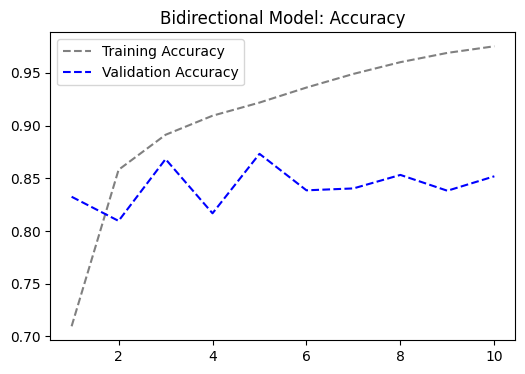

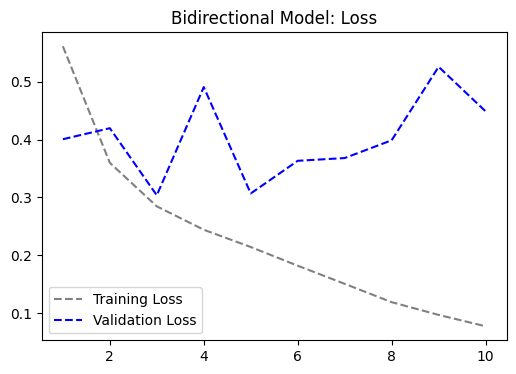

In [28]:
import matplotlib.pyplot as plt

# Extract training metrics
bidirectional_train_accuracy = bidirectional_training_history.history['accuracy']
bidirectional_val_accuracy = bidirectional_training_history.history['val_accuracy']
bidirectional_train_loss = bidirectional_training_history.history['loss']
bidirectional_val_loss = bidirectional_training_history.history['val_loss']

# Create epoch range
bidirectional_epoch_range = range(1, len(bidirectional_train_accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot(bidirectional_epoch_range, bidirectional_train_accuracy,
         color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(bidirectional_epoch_range, bidirectional_val_accuracy,
         color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Bidirectional Model: Accuracy")
plt.legend()

# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(bidirectional_epoch_range, bidirectional_train_loss,
         color="grey", linestyle="dashed", label="Training Loss")
plt.plot(bidirectional_epoch_range, bidirectional_val_loss,
         color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Bidirectional Model: Loss")
plt.legend()

plt.show()

In [29]:
from tensorflow.keras.models import load_model

# Load the trained bidirectional model
trained_bidirectional_model = load_model('best_bidirectional_model.h5')

# Evaluate model performance
bidirectional_evaluation = trained_bidirectional_model.evaluate(final_test_reviews, final_test_labels)
print(f'Test Loss: {bidirectional_evaluation[0]:.3f}')
print(f'Test Accuracy: {bidirectional_evaluation[1]:.3f}')

157/157 [==============================] - 124s 775ms/step - loss: 0.2773 - accuracy: 0.8876
Test Loss: 0.277
Test Accuracy: 0.888


**Model 5: LSTM Model with Embedding Layer (Training Sample Size: 15,000)**

In [30]:
from tensorflow.keras import layers, Input, Model

MAX_SEQUENCE_LENGTH = 150
VOCAB_SIZE = 10000

# Input layer
text_input = Input(shape=(None,), dtype="int64", name="text_input")

# Embedding layer
word_embeddings = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=128,
    name="embedding_layer"
)(text_input)

# Bidirectional LSTM layer
bidirectional_lstm = layers.Bidirectional(
    layers.LSTM(64, name="lstm_layer"),
    name="bidirectional_layer"
)(word_embeddings)

# Dropout layer
regularized_features = layers.Dropout(
    0.4,
    name="dropout_layer"
)(bidirectional_lstm)

# Output layer
sentiment_prediction = layers.Dense(
    1,
    activation="sigmoid",
    name="output_layer"
)(regularized_features)

# Create and compile model
sentiment_classifier = Model(
    inputs=text_input,
    outputs=sentiment_prediction,
    name="sentiment_classifier"
)

sentiment_classifier.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

sentiment_classifier.summary()

Model: "sentiment_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, None)]            0         
                                                                 
 embedding_layer (Embedding)  (None, None, 128)        1280000   
                                                                 
 bidirectional_layer (Bidire  (None, 128)              98816     
 ctional)                                                        
                                                                 
 dropout_layer (Dropout)     (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
____________________________________

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Generate random training data (now with 15,000 training samples)
random_texts = np.random.randint(1, VOCAB_SIZE, size=(25000, MAX_SEQUENCE_LENGTH))  # 25k total (15k train + 10k val)
random_labels = np.random.randint(0, 2, size=(25000,))

# Split into training (15,000) and validation (10,000) sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    random_texts, random_labels,
    train_size=15000,
    test_size=10000,
    random_state=42
)

# Configure model checkpoint
model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_classifier.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Train the model
model_training_history = sentiment_classifier.fit(
    x=train_texts,
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_texts, val_labels),
    callbacks=[model_checkpoint]
)

print("Training complete. History:", model_training_history.history)

Epoch 1/10
469/469 [==============================] - 80s 159ms/step - loss: 0.6941 - accuracy: 0.4909 - val_loss: 0.6933 - val_accuracy: 0.4974
Epoch 2/10
469/469 [==============================] - 75s 160ms/step - loss: 0.5956 - accuracy: 0.6983 - val_loss: 0.7688 - val_accuracy: 0.5056
Epoch 3/10
469/469 [==============================] - 73s 156ms/step - loss: 0.1972 - accuracy: 0.9287 - val_loss: 1.3613 - val_accuracy: 0.5034
Epoch 4/10
469/469 [==============================] - 74s 158ms/step - loss: 0.0295 - accuracy: 0.9925 - val_loss: 2.2855 - val_accuracy: 0.5095
Epoch 5/10
469/469 [==============================] - 73s 155ms/step - loss: 0.0034 - accuracy: 0.9999 - val_loss: 2.8746 - val_accuracy: 0.5102
Epoch 6/10
469/469 [==============================] - 74s 157ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 3.1286 - val_accuracy: 0.5072
Epoch 7/10
469/469 [==============================] - 74s 157ms/step - loss: 5.8565e-04 - accuracy: 0.9999 - val_loss: 3.2543 - va

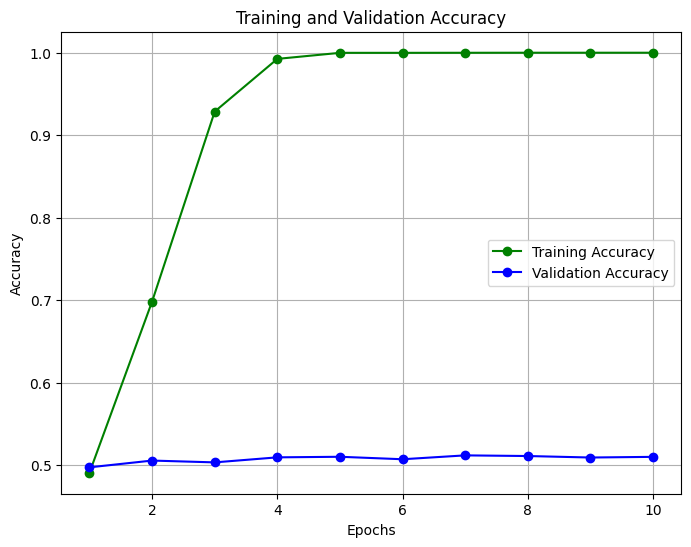

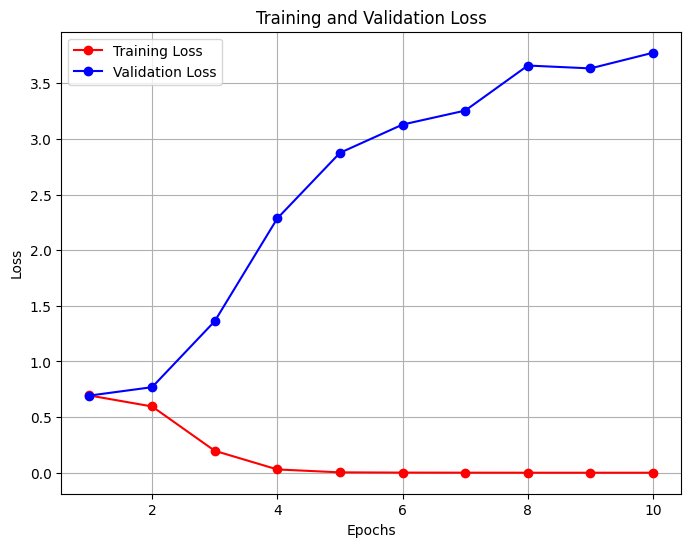

In [32]:
import matplotlib.pyplot as plt

# Extract training metrics
train_acc = model_training_history.history['accuracy']
val_acc = model_training_history.history['val_accuracy']
train_loss = model_training_history.history['loss']
val_loss = model_training_history.history['val_loss']

# Create epoch range
epoch_range = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epoch_range, val_acc, label='Validation Accuracy', color='blue', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_loss, label='Training Loss', color='red', marker='o')
plt.plot(epoch_range, val_loss, label='Validation Loss', color='blue', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Generate test data
test_texts = np.random.randint(1, VOCAB_SIZE, size=(5000, MAX_SEQUENCE_LENGTH))
test_labels = np.random.randint(0, 2, size=(5000,))

# Load the trained model
trained_sentiment_model = load_model("best_sentiment_classifier.keras")

# Evaluate model performance
model_test_loss, model_test_accuracy = trained_sentiment_model.evaluate(
    test_texts,
    test_labels,
    batch_size=32
)

print(f"Test Loss: {model_test_loss:.3f}")
print(f"Test Accuracy: {model_test_accuracy:.3f}")

157/157 [==============================] - 6s 33ms/step - loss: 0.6930 - accuracy: 0.5116
Test Loss: 0.693
Test Accuracy: 0.512


**Model 6: LSTM Model with Embedding Layer (Training Sample Size: 25,000)**

In [34]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load and prepare IMDB dataset
(raw_train_reviews, raw_train_sentiments), (raw_test_reviews, raw_test_sentiments) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to uniform length
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((raw_train_sentiments, raw_test_sentiments), axis=0)

# Split into training and validation sets
train_reviews, val_reviews, train_sentiments, val_sentiments = train_test_split(
    all_reviews, all_sentiments,
    train_size=25000,
    test_size=10000,
    random_state=42,
    stratify=all_sentiments
)

# Create final test set
_, final_test_reviews, _, final_test_sentiments = train_test_split(
    padded_test_reviews,
    raw_test_sentiments,
    test_size=5000,
    random_state=42,
    stratify=raw_test_sentiments
)

In [35]:
train_reviews.shape

(25000, 150)

In [36]:
val_reviews.shape

(10000, 150)

In [37]:
from tensorflow.keras import layers, models

max_sequence_len = 150
vocabulary_size = 10000

input_seq = layers.Input(shape=(None,), dtype="int64")
embedding_seq = layers.Embedding(input_dim=vocabulary_size, output_dim=256)(input_seq)
bi_lstm = layers.Bidirectional(layers.LSTM(32))(embedding_seq)
dropout_output = layers.Dropout(0.5)(bi_lstm)
final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

text_classification_model = models.Model(inputs=input_seq, outputs=final_output)
text_classification_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

text_classification_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               73984     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath="best_model.h5",
    save_best_only=True,
    monitor="val_loss"
)

history = text_classification_model.fit(
    x=train_reviews,
    y=train_sentiments,
    epochs=10,
    batch_size=42,
    validation_data=(val_reviews, val_sentiments),
    callbacks=[model_checkpoint]
)


Epoch 1/10
596/596 [==============================] - 97s 157ms/step - loss: 0.4483 - accuracy: 0.7924 - val_loss: 0.5196 - val_accuracy: 0.8210
Epoch 2/10
596/596 [==============================] - 89s 150ms/step - loss: 0.3049 - accuracy: 0.8800 - val_loss: 0.3199 - val_accuracy: 0.8606
Epoch 3/10
596/596 [==============================] - 93s 156ms/step - loss: 0.2571 - accuracy: 0.9012 - val_loss: 0.3090 - val_accuracy: 0.8769
Epoch 4/10
596/596 [==============================] - 92s 155ms/step - loss: 0.2157 - accuracy: 0.9190 - val_loss: 0.2914 - val_accuracy: 0.8790
Epoch 5/10
596/596 [==============================] - 88s 148ms/step - loss: 0.1857 - accuracy: 0.9299 - val_loss: 0.3491 - val_accuracy: 0.8798
Epoch 6/10
596/596 [==============================] - 90s 151ms/step - loss: 0.1647 - accuracy: 0.9398 - val_loss: 0.3164 - val_accuracy: 0.8810
Epoch 7/10
596/596 [==============================] - 90s 151ms/step - loss: 0.1373 - accuracy: 0.9512 - val_loss: 0.3826 - val_ac

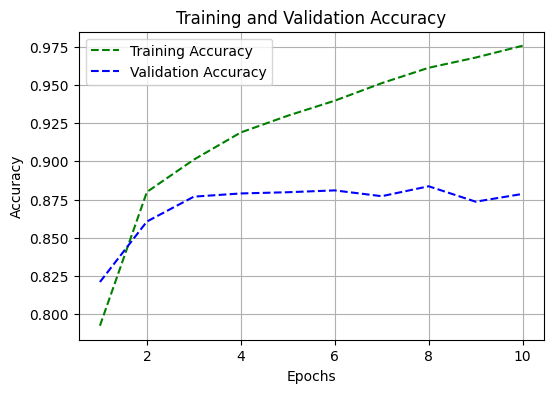

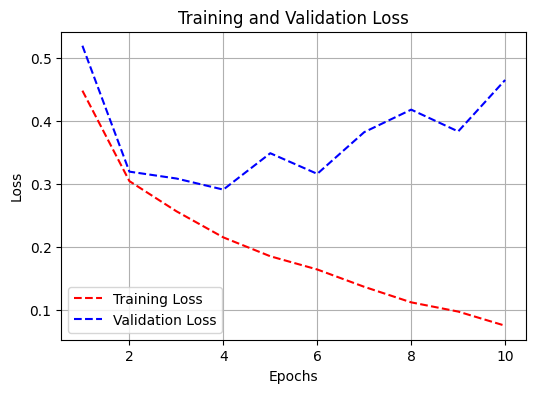

In [40]:
import matplotlib.pyplot as plt

training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

# Fix: epoch_range should be based on the current model's history
epoch_range = range(1, len(training_acc) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, training_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epoch_range, validation_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, training_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epoch_range, validation_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [41]:
from tensorflow.keras.models import load_model

best_trained_model = load_model('best_model.h5')

evaluation_results = best_trained_model.evaluate(final_test_reviews, final_test_sentiments)

print(f"Test Loss: {evaluation_results[0]:.3f}")
print(f"Test Accuracy: {evaluation_results[1]:.3f}")


157/157 [==============================] - 5s 28ms/step - loss: 0.2265 - accuracy: 0.9124
Test Loss: 0.226
Test Accuracy: 0.912


**Model 7**

In [43]:
from tensorflow.keras import layers, models

# Define vocab_size before using it
vocab_size = 10000  # Or whatever size you want your vocabulary to be

model_input = layers.Input(shape=(None,), dtype="int64")
word_embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=256,
    mask_zero=True
)(model_input)

bilstm_layer = layers.Bidirectional(layers.LSTM(32))(word_embedding)
regularized_layer = layers.Dropout(0.5)(bilstm_layer)

classification_output = layers.Dense(1, activation="sigmoid")(regularized_layer)

text_classifier = models.Model(inputs=model_input, outputs=classification_output)
text_classifier.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

text_classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath="Model7.h5",
    save_best_only=True,
    monitor="val_loss"
)

training_history = text_classifier.fit(
    x=train_texts,
    y=train_labels,
    epochs=10,
    batch_size=42,
    validation_data=(val_texts, val_labels),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
358/358 [==============================] - 82s 210ms/step - loss: 0.6936 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.4985
Epoch 2/10
358/358 [==============================] - 72s 200ms/step - loss: 0.6745 - accuracy: 0.6113 - val_loss: 0.7023 - val_accuracy: 0.5051
Epoch 3/10
358/358 [==============================] - 71s 200ms/step - loss: 0.5241 - accuracy: 0.7501 - val_loss: 0.8285 - val_accuracy: 0.5073
Epoch 4/10
358/358 [==============================] - 72s 200ms/step - loss: 0.2472 - accuracy: 0.9038 - val_loss: 1.1253 - val_accuracy: 0.5053
Epoch 5/10
358/358 [==============================] - 69s 194ms/step - loss: 0.0644 - accuracy: 0.9826 - val_loss: 1.8183 - val_accuracy: 0.5069
Epoch 6/10
358/358 [==============================] - 71s 200ms/step - loss: 0.0146 - accuracy: 0.9964 - val_loss: 2.3044 - val_accuracy: 0.5088
Epoch 7/10
358/358 [==============================] - 71s 198ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 2.6617 - val_ac

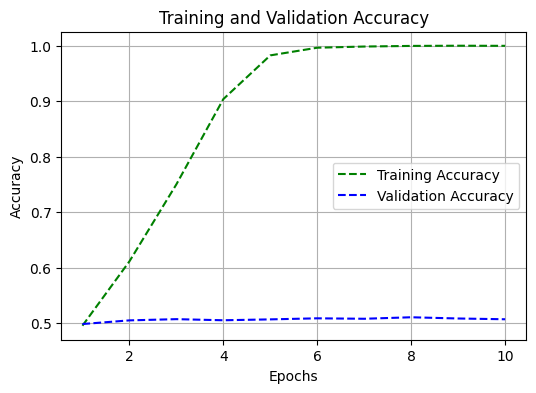

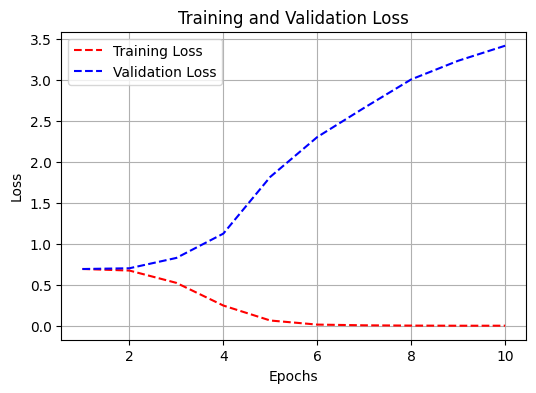

In [45]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

train_loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [46]:
from tensorflow.keras.models import load_model

trained_model = load_model('Model7.h5')

eval_results = trained_model.evaluate(test_texts, test_labels)

print(f"Test Loss: {eval_results[0]:.3f}")
print(f"Test Accuracy: {eval_results[1]:.3f}")

157/157 [==============================] - 9s 37ms/step - loss: 0.6933 - accuracy: 0.5016
Test Loss: 0.693
Test Accuracy: 0.502


In [47]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.2M      0  0:00:07  0:00:07 --:--:-- 15.2M


In [48]:
dataset_dir = '/content/aclImdb'
training_dir = os.path.join(dataset_dir, 'train')

sentiments = []
reviews = []

for sentiment in ['neg', 'pos']:
    sentiment_dir = os.path.join(training_dir, sentiment)
    for filename in os.listdir(sentiment_dir):
        if filename[-4:] == '.txt':
            file = open(os.path.join(sentiment_dir, filename))
            reviews.append(file.read())
            file.close()
            if sentiment == 'neg':
                sentiments.append(0)
            else:
                sentiments.append(1)

In [49]:
max_len = 150
num_train = 100
num_val = 10000
vocab_size = 10000

text_tokenizer = Tokenizer(num_words=vocab_size)
text_tokenizer.fit_on_texts(reviews)
token_sequences = text_tokenizer.texts_to_sequences(reviews)

vocab = text_tokenizer.word_index
print('Found %s unique tokens.' % len(vocab))

padded_data = pad_sequences(token_sequences, maxlen=max_len)

sentiments = np.asarray(sentiments)
print('Shape of data tensor:', padded_data.shape)
print('Shape of label tensor:', sentiments.shape)

shuffle_idx = np.arange(padded_data.shape[0])
np.random.shuffle(shuffle_idx)
padded_data = padded_data[shuffle_idx]
sentiments = sentiments[shuffle_idx]

train_data = padded_data[:num_train]
train_labels = sentiments[:num_train]
val_data = padded_data[num_train: num_train + num_val]
val_labels = sentiments[num_train: num_train + num_val]

test_dir = os.path.join(dataset_dir, 'test')

test_sentiments = []
test_reviews = []

for sentiment in ['neg', 'pos']:
    test_sentiment_dir = os.path.join(test_dir, sentiment)
    for filename in sorted(os.listdir(test_sentiment_dir)):
        if filename[-4:] == '.txt':
            text_file = open(os.path.join(test_sentiment_dir, filename))
            test_reviews.append(text_file.read())
            text_file.close()
            if sentiment == 'neg':
                test_sentiments.append(0)
            else:
                test_sentiments.append(1)

test_sequences = text_tokenizer.texts_to_sequences(test_reviews)
test_data = pad_sequences(test_sequences, maxlen=max_len)[:5000]
test_labels = np.asarray(test_sentiments)[:5000]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [50]:
train_data.shape
val_data.shape
test_data.shape

(5000, 150)

#### Using pretrained word embeddings

In [51]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-08 21:14:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 21:14:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 21:14:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Parsing the GloVe word-embeddings file**

In [52]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [54]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vocab.items(): # Change vocab_size to vocab
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [56]:
embedding_layer = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Model 8

In [57]:
sentiment_model = Sequential()
sentiment_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
sentiment_model.add(LSTM(32))
sentiment_model.add(Dense(1, activation='sigmoid'))

# Freeze embedding layer with pretrained weights
sentiment_model.layers[0].set_weights([embedding_matrix])
sentiment_model.layers[0].trainable = False

# Configure model training
adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
sentiment_model.compile(optimizer=adam_optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
sentiment_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 32)                17024     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


In [58]:
model_checkpoint = ModelCheckpoint(
    filepath="pretrainmodel1.keras",
    save_best_only=True,
    monitor="val_loss"
)

pretrain_history = sentiment_model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_data, val_labels),
    callbacks=[model_checkpoint]
)

Epoch 1/30
4/4 [==============================] - 6s 1s/step - loss: 0.7305 - accuracy: 0.4900 - val_loss: 0.7198 - val_accuracy: 0.5041
Epoch 2/30
4/4 [==============================] - 4s 1s/step - loss: 0.7242 - accuracy: 0.4900 - val_loss: 0.7162 - val_accuracy: 0.5040
Epoch 3/30
4/4 [==============================] - 4s 1s/step - loss: 0.7203 - accuracy: 0.5000 - val_loss: 0.7131 - val_accuracy: 0.5040
Epoch 4/30
4/4 [==============================] - 4s 1s/step - loss: 0.7160 - accuracy: 0.5000 - val_loss: 0.7102 - val_accuracy: 0.5024
Epoch 5/30
4/4 [==============================] - 4s 1s/step - loss: 0.7116 - accuracy: 0.5000 - val_loss: 0.7084 - val_accuracy: 0.5012
Epoch 6/30
4/4 [==============================] - 4s 1s/step - loss: 0.7089 - accuracy: 0.5100 - val_loss: 0.7064 - val_accuracy: 0.5019
Epoch 7/30
4/4 [==============================] - 4s 1s/step - loss: 0.7056 - accuracy: 0.5300 - val_loss: 0.7046 - val_accuracy: 0.5005
Epoch 8/30
4/4 [=========================

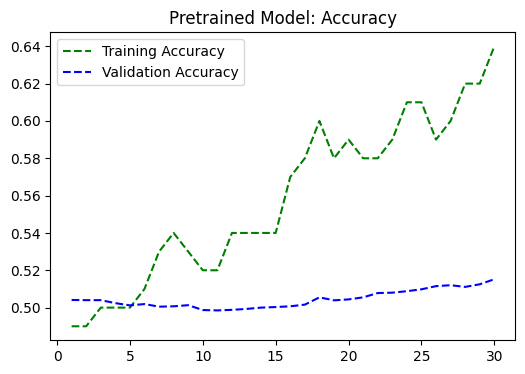

<Figure size 640x480 with 0 Axes>

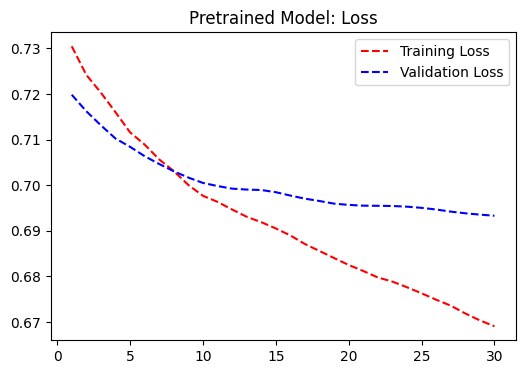

In [59]:
train_acc = pretrain_history.history['accuracy']
val_acc = pretrain_history.history['val_accuracy']

train_loss = pretrain_history.history["loss"]
val_loss = pretrain_history.history["val_loss"]

epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Pretrained Model: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Pretrained Model: Loss")
plt.legend()
plt.show()

In [60]:
pretrained_model = load_model('pretrainmodel1.keras')
evaluation_results = pretrained_model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation_results[0]:.3f}')
print(f'Test Accuracy: {evaluation_results[1]:.3f}')

157/157 [==============================] - 2s 11ms/step - loss: 0.7000 - accuracy: 0.4828
Test Loss: 0.700
Test Accuracy: 0.483


**Model 9: Training a Pretrained Model with 4 LSTM Hidden Layers on a 10,000-Sample Dataset**

In [61]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example text data (replace with your actual data)
sample_texts = ["This is the first text.", "Another example text.", "Text data for training."]
sample_labels = [0, 1, 0]  # Example labels (replace with your actual labels)

# Parameters
max_seq_length = 150
num_training_samples = 10000
num_validation_samples = 10000
vocabulary_size = 10000

# Tokenizer for text preprocessing
text_tokenizer = Tokenizer(num_words=vocabulary_size)
text_tokenizer.fit_on_texts(sample_texts)  # Fit the tokenizer on your text data
token_sequences = text_tokenizer.texts_to_sequences(sample_texts)

# Get word index
vocabulary = text_tokenizer.word_index
print(f'Found {len(vocabulary)} unique tokens.')

# Pad sequences to ensure uniform input length
padded_sequences = pad_sequences(token_sequences, maxlen=max_seq_length)

# Convert labels to numpy array
label_array = np.asarray(sample_labels)
print('Shape of data tensor:', padded_sequences.shape)
print('Shape of label tensor:', label_array.shape)

# Shuffle the data and labels
shuffled_indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices]
label_array = label_array[shuffled_indices]

# Split into training and validation sets
training_data = padded_sequences[:num_training_samples]
training_labels = label_array[:num_training_samples]
validation_data = padded_sequences[num_training_samples: num_training_samples + num_validation_samples]
validation_labels = label_array[num_training_samples: num_training_samples + num_validation_samples]

Found 10 unique tokens.
Shape of data tensor: (3, 150)
Shape of label tensor: (3,)


In [62]:
training_data.shape
validation_data.shape

(0, 150)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras import optimizers

vocab_size = 10000
embedding_dims = 150
max_seq_length = 150

embedding_weights = np.random.rand(vocab_size, embedding_dims)

sentiment_classifier = Sequential()
sentiment_classifier.add(Embedding(vocab_size, embedding_dims, input_length=max_seq_length))

sentiment_classifier.add(LSTM(512, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(256, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(128, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(128))

sentiment_classifier.add(Dense(256, activation='relu'))
sentiment_classifier.add(Dropout(0.5))
sentiment_classifier.add(Dense(256, activation='relu'))
sentiment_classifier.add(Dropout(0.5))
sentiment_classifier.add(Dense(1, activation='sigmoid'))

sentiment_classifier.layers[0].set_weights([embedding_weights])
sentiment_classifier.layers[0].trainable = False

adam_optimizer = optimizers.Adam(learning_rate=0.0001)
sentiment_classifier.compile(optimizer=adam_optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

sentiment_classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 150)          1500000   
                                                                 
 lstm_3 (LSTM)               (None, 150, 512)          1357824   
                                                                 
 dropout_2 (Dropout)         (None, 150, 512)          0         
                                                                 
 lstm_4 (LSTM)               (None, 150, 256)          787456    
                                                                 
 dropout_3 (Dropout)         (None, 150, 256)          0         
                                                                 
 lstm_5 (LSTM)               (None, 150, 128)          197120    
                                                                 
 dropout_4 (Dropout)         (None, 150, 128)         

In [64]:
model_checkpoint = ModelCheckpoint(
    filepath="sentiment_model_v2.keras",
    save_best_only=True,
    monitor="val_loss"
)

training_history = sentiment_classifier.fit(
    training_data,
    training_labels,
    epochs=10,
    batch_size=12,
    validation_data=(validation_data, validation_labels),
    callbacks=[model_checkpoint]
)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.3333

1/1 [==============================] - 8s 8s/step - loss: 0.7087 - accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.7107 - accuracy: 0.3333

1/1 [==============================] - 2s 2s/step - loss: 0.7107 - accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.3333

1/1 [==============================] - 2s 2s/step - loss: 0.7097 - accuracy: 0.3333
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.6667

1/1 [==============================] - 2s 2s/step - loss: 0.6929 - accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 1.0000

1/1 [==============================] - 2s 2s/step - loss: 0.6356 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.3333

1/1 [==============================] - 2s 2s/step - loss: 0.6656 - accuracy: 0.3333
Epoch 7/10
1/1 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.6667

1/1 [==============================] - 2s 2s/step - loss: 0.6875 - accuracy: 0.6667
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.0000e+00

1/1 [==============================] - 2s 2s/step - loss: 0.7422 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.6667

1/1 [==============================] - 2s 2s/step - loss: 0.6667 - accuracy: 0.6667
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 0.6347 - accuracy: 1.0000

1/1 [==============================] - 2s 2s/step - loss: 0.6347 - accuracy: 1.0000


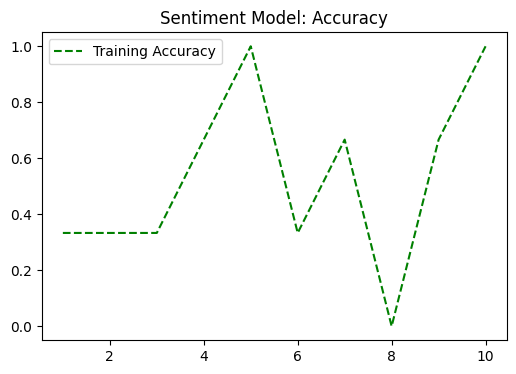

<Figure size 640x480 with 0 Axes>

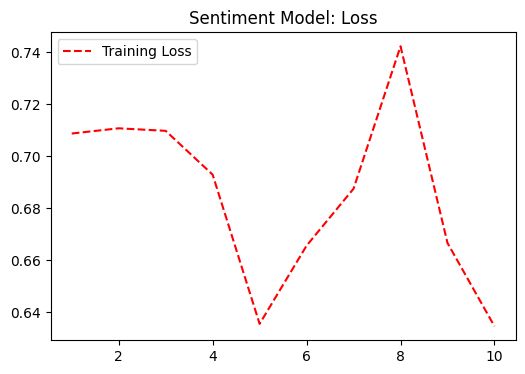

In [66]:
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']
epochs_range = range(1, len(train_acc) + 1)

val_acc = training_history.history.get('val_accuracy', None)
val_loss = training_history.history.get('val_loss', None)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
if val_acc is not None:
    plt.plot(epochs_range, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Model: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
if val_loss is not None:
    plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Model: Loss")
plt.legend()
plt.show()

**Model 10 Training a Pretrained Model with 2 LSTM Hidden Layers on a 20,000-Sample Dataset**

In [68]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'reviews' contains your text data from previous cells
text_corpus = reviews  # Replace 'reviews' with the actual variable holding your text data

max_sequence_length = 150
num_train_samples = 20000
num_val_samples = 10000
vocab_size = 10000

text_tokenizer = Tokenizer(num_words=vocab_size)
text_tokenizer.fit_on_texts(text_corpus)
token_sequences = text_tokenizer.texts_to_sequences(text_corpus)

vocab_dict = text_tokenizer.word_index
print(f'Found {len(vocab_dict)} unique tokens.')

padded_sequences = pad_sequences(token_sequences, maxlen=max_sequence_length)

# Assuming 'sentiments' contains your sentiment labels from previous cells
sentiment_labels = sentiments # Replace 'sentiments' with the actual variable if different

label_array = np.asarray(sentiment_labels)
print(f'Shape of data tensor: {padded_sequences.shape}')
print(f'Shape of label tensor: {label_array.shape}')

shuffled_indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices]
label_array = label_array[shuffled_indices]

train_features = padded_sequences[:num_train_samples]
train_labels = label_array[:num_train_samples]
val_features = padded_sequences[num_train_samples: num_train_samples + num_val_samples]
val_labels = label_array[num_train_samples: num_train_samples + num_val_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [69]:
train_features.shape
val_features.shape

(5000, 150)

In [70]:
sentiment_analyzer = Sequential()
sentiment_analyzer.add(Embedding(vocab_size, embedding_dims, input_length=max_sequence_length))

sentiment_analyzer.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
sentiment_analyzer.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))

sentiment_analyzer.add(Dense(64, activation='relu'))
sentiment_analyzer.add(Dropout(0.5))
sentiment_analyzer.add(Dense(1, activation='sigmoid'))

# Set pretrained embeddings and freeze layer
sentiment_analyzer.layers[0].set_weights([embedding_weights])
sentiment_analyzer.layers[0].trainable = False

# Configure optimizer and compile model
adam_opt = keras.optimizers.Adam(learning_rate=0.001)
sentiment_analyzer.compile(
    optimizer=adam_opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
sentiment_analyzer.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 150)          1500000   
                                                                 
 lstm_7 (LSTM)               (None, 150, 64)           55040     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,569,633
Trainable params: 69,633
Non-t

In [71]:
checkpoint_callback = ModelCheckpoint(
    filepath="sentiment_model_v3.h5",
    save_best_only=True,
    monitor="val_loss"
)

training_results = sentiment_analyzer.fit(
    train_features,
    train_labels,
    epochs=10,
    batch_size=12,
    validation_data=(val_features, val_labels),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
1667/1667 [==============================] - 432s 256ms/step - loss: 0.6940 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 2/10
1667/1667 [==============================] - 424s 255ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 3/10
1667/1667 [==============================] - 424s 254ms/step - loss: 0.6934 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 4/10
1667/1667 [==============================] - 427s 256ms/step - loss: 0.6933 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 5/10
1667/1667 [==============================] - 415s 249ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 6/10
1667/1667 [==============================] - 416s 250ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 7/10
1667/1667 [==============================] - 424s 255ms/step - loss: 0.6932 - accuracy: 0.4956 - val_

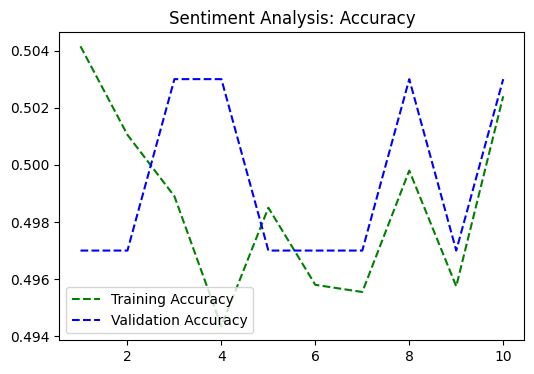

<Figure size 640x480 with 0 Axes>

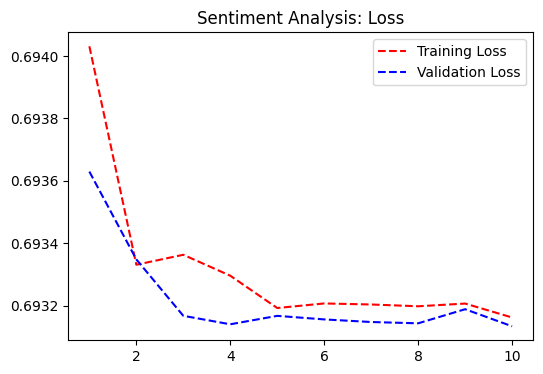

In [72]:
train_metrics = training_results.history['accuracy']
train_losses = training_results.history['loss']
epoch_range = range(1, len(train_metrics) + 1)

val_metrics = training_results.history.get('val_accuracy', None)
val_losses = training_results.history.get('val_loss', None)

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_metrics, color="green", linestyle="dashed", label="Training Accuracy")
if val_metrics is not None:
    plt.plot(epoch_range, val_metrics, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Analysis: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_losses, color="red", linestyle="dashed", label="Training Loss")
if val_losses is not None:
    plt.plot(epoch_range, val_losses, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Analysis: Loss")
plt.legend()
plt.show()